In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

pd.options.mode.chained_assignment = None  # default='warn'
from statsmodels.stats import multitest
from scipy import stats

### ReadZs from 10Xv3 sequencing correlations with MOp MERFISH

In [2]:
#input is from the gene_cell table, grouped on ontologies matching 10Xv3 dataset
#script is in ../analysis/mop_peripheral_to_rz_gene_annots.py
#also filtered:
#1. Dropped gene/cells which have fewer than 5 gene spots of interest
#2. Dropped gene/cell-type/samples with fewer than 20 cells

mop_df = pd.read_csv('../outputs/gene_ontology/MOp_periphal_ReadZs_gene_ontology.csv')
mop_df

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,0.087413,26.992258,46.958252,3.938975,8.183035e-05,2.932678e-04
1,m1s1,Acta2,L5 ET,51,6.0,698.0,0.032479,2.767631,6.067670,1.123562,2.611988e-01,3.677689e-01
2,m1s1,Acta2,L5 IT,257,6.0,654.0,0.094270,25.067569,29.188310,4.639891,3.485936e-06,1.526668e-05
3,m1s1,Acta2,L6 CT,26,5.0,304.0,0.176217,4.241585,3.271222,2.345164,1.901872e-02,4.083275e-02
4,m1s1,Acta2,L6 IT,85,6.0,569.0,0.035714,2.599184,10.194193,0.814068,4.156061e-01,5.274491e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
11535,m2s6,Wnt7b,L5 ET,85,9.0,884.0,0.070501,2.535220,7.512154,0.924982,3.549752e-01,4.683952e-01
11536,m2s6,Wnt7b,L5 IT,867,19.0,687.0,0.056877,51.876213,48.954780,7.414310,1.223466e-13,1.074490e-12
11537,m2s6,Wnt7b,L6 CT,248,8.0,464.0,0.017007,7.288136,23.892058,1.491041,1.359506e-01,2.179895e-01
11538,m2s6,Wnt7b,L6 IT,165,8.0,661.0,0.100309,14.275360,15.731385,3.599180,3.192220e-04,1.036237e-03


In [3]:
#read in the 10X ReadZs gene-level dataset
rz_10x = pd.read_csv('../outputs/readzs/gene_level/MOp_10Xv3.csv')
rz_10x.head()

,gene,window,ontology,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
0,Tmem163,chr1_Tmem163_minus,Sst,124,1.0,-1.236121,0.0,0.0,True,1.781479,0.0
1,Tmem163,chr1_Tmem163_minus,L2/3 IT,4507,1.0,-1.233786,0.0,0.0,True,1.781479,0.0
2,Tmem163,chr1_Tmem163_minus,L6 IT,4209,2.0,-1.232087,0.0,0.0,True,1.781479,0.0
3,Tmem163,chr1_Tmem163_minus,L6 CT,1452,1.0,-1.230884,0.0,0.0,True,1.781479,0.0
4,Tmem163,chr1_Tmem163_minus,Pvalb,100,1.0,-1.220906,0.0,0.0,True,1.781479,0.0


In [5]:
#merge the SRRS and ReadZs
m = mop_df.merge(rz_10x, on=['gene','ontology'])
m.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,...,bh_p,window,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
0,m1s1,Adamts4,Oligo,221,11.0,167.0,-0.123967,-18.170619,15.189633,-4.662256,...,1.377587e-05,chr1_Adamts4_plus,3027,4.0,0.1319,0.0,0.0,True,0.46856,0.0
1,m1s2,Adamts4,Oligo,994,12.0,191.5,-0.055245,-52.013081,66.673711,-6.369939,...,1.316992e-09,chr1_Adamts4_plus,3027,4.0,0.1319,0.0,0.0,True,0.46856,0.0
2,m1s3,Adamts4,Oligo,1042,12.0,171.0,-0.046269,-55.887216,70.284664,-6.666259,...,1.988288e-10,chr1_Adamts4_plus,3027,4.0,0.1319,0.0,0.0,True,0.46856,0.0
3,m1s4,Adamts4,Oligo,1943,14.0,206.0,-0.056962,-112.033154,120.657374,-10.199283,...,2.595750e-23,chr1_Adamts4_plus,3027,4.0,0.1319,0.0,0.0,True,0.46856,0.0
4,m1s5,Adamts4,Oligo,1842,14.0,212.0,-0.055465,-101.125782,110.334767,-9.627327,...,7.615113e-21,chr1_Adamts4_plus,3027,4.0,0.1319,0.0,0.0,True,0.46856,0.0


In [9]:
#calculate pearson correlations and BH corrected p-values
corr_data = {
    'gene':[],
    'sample_id':[],
    'num_celltypes':[],
    'med_SRRS_cells_per_celltype':[],
    'pearson_r':[],
    'pearson_p':[],
}

#can't correlate ReadZs/SRRS gene/samples with only a single ontology
gene_sample_ontology_df = m.groupby(['gene','sample_id']).filter(lambda g: g['ontology'].nunique() >= 2)

for (gene,sample_name),g in gene_sample_ontology_df.groupby(['gene','sample_id']):
    r,p = stats.pearsonr(g['med_score'],g['median_z_scaled'])
    
    corr_data['gene'].append(gene)
    corr_data['sample_id'].append(sample_name)
    corr_data['num_celltypes'].append(g['ontology'].nunique())
    corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
    corr_data['pearson_r'].append(r)
    corr_data['pearson_p'].append(p)

#BH multiple hypothesis correction
corr_df = pd.DataFrame(corr_data).sort_values('pearson_p')
_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)

corr_df['bh_pearson_p'] = adj_p
corr_df['significant'] = corr_df['bh_pearson_p'].le(0.05)

corr_df

,gene,sample_id,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
550,Timp3,m1s5,9,147.0,-0.965125,0.000025,0.015779,True
549,Timp3,m1s4,10,119.5,-0.930377,0.000094,0.029565,True
547,Timp3,m1s2,12,100.0,-0.874243,0.000200,0.040181,True
72,Ccdc3,m1s6,5,87.0,-0.996422,0.000257,0.040181,True
76,Ccdc3,m2s4,5,297.0,-0.994372,0.000506,0.063403,False
...,...,...,...,...,...,...,...,...
81,Ccdc80,m1s3,2,317.0,-1.000000,1.000000,1.000000,False
80,Ccdc80,m1s2,2,539.5,-1.000000,1.000000,1.000000,False
79,Ccdc80,m1s1,2,220.0,1.000000,1.000000,1.000000,False
521,Tbc1d4,m2s4,2,104.5,-1.000000,1.000000,1.000000,False


In [10]:
#only Timp3 and Ccdc3 are significant
corr_df[corr_df['significant']]

,gene,sample_id,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
550,Timp3,m1s5,9,147.0,-0.965125,0.000025,0.015779,True
549,Timp3,m1s4,10,119.5,-0.930377,0.000094,0.029565,True
547,Timp3,m1s2,12,100.0,-0.874243,0.000200,0.040181,True
72,Ccdc3,m1s6,5,87.0,-0.996422,0.000257,0.040181,True


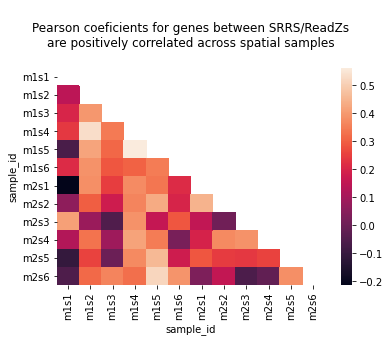

In [14]:
hm_df = corr_df.pivot(
    index='gene',
    columns='sample_id',
    values='pearson_r',
).corr()
mask = np.zeros_like(hm_df)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    hm_df,
    mask=mask,
)
plt.title(
"""
Pearson coeficients for genes between SRRS/ReadZs
are positively correlated across spatial samples
"""
)
plt.show()
plt.close()

In [19]:
gene_sample_ontology_df.head().T

,1,3,4,5,7
sample_id,m1s2,m1s4,m1s5,m1s6,m2s2
gene,Adamts4,Adamts4,Adamts4,Adamts4,Adamts4
ontology,Oligo,Oligo,Oligo,Oligo,Oligo
num_cells,994,1943,1842,1301,1298
med_gene_spots,12,14,14,11,13
med_spots,191.5,206,212,180,212
med_score,-0.0552448,-0.056962,-0.0554651,-0.0625,-0.0369843
score_sum,-52.0131,-112.033,-101.126,-67.2509,-54.212
var_sum,66.6737,120.657,110.335,95.9293,82.9951
z,-6.36994,-10.1993,-9.62733,-6.86629,-5.95072


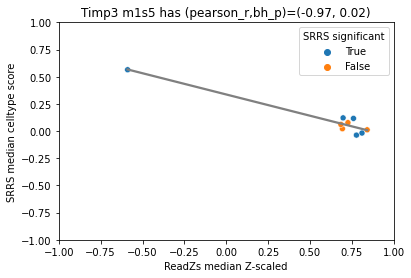

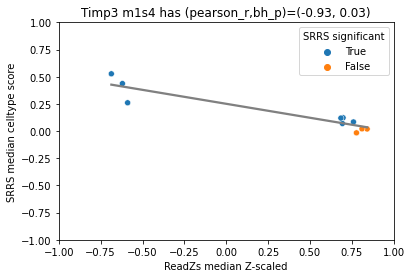

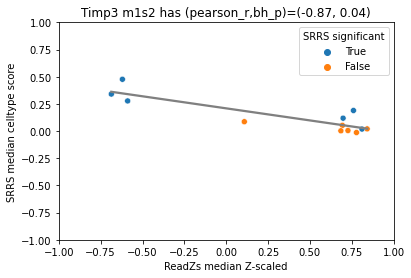

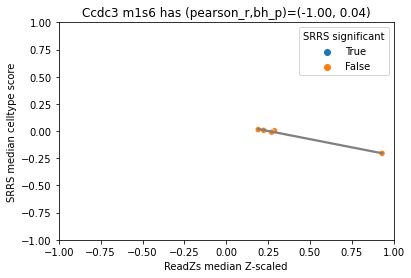

In [26]:
#pdf to save out to
pdf = matplotlib.backends.backend_pdf.PdfPages("significant_srrs_10X_readzs_correlations.pdf")

for i,r in corr_df[corr_df['significant']].iterrows():
    gene,sample_name = r['gene'],r['sample_id']
    g = gene_sample_ontology_df[
        gene_sample_ontology_df['gene'].eq(gene) & gene_sample_ontology_df['sample_id'].eq(sample_name)
    ]
    
    g['SRRS significant'] = g['bh_p'].le(0.05).astype('str')
    
    
    fig = plt.figure()
    sns.scatterplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'SRRS significant',
        hue_order = ['True','False'],
        data = g,
    )
    sns.regplot(
        x = 'median_z_scaled',
        y = 'med_score',
        color = 'grey',
        scatter = False,
        ci = None,
        data = g,
    )
    
    plt.xlabel('ReadZs median Z-scaled')
    plt.ylabel('SRRS median celltype score')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.title('{} {} has (pearson_r,bh_p)=({:.2f}, {:.2f})'.format(
        gene,sample_name,r['pearson_r'],r['bh_pearson_p']))
    
    plt.show()
    pdf.savefig(fig)
    plt.close()
    
pdf.close()